In [23]:
# !pip install tensorflow
!pip install h5py

In [24]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report
from tensorflow.keras import models, layers, optimizers
from tensorflow.python.keras.saving import hdf5_format
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
import h5py, itertools, collections
import itertools
# import kerastuner
# from kerastuner.tuners import RandomSearch
from tensorflow.keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.models import Model
from keras.models import load_model

In [25]:
import tensorflow as tf

In [27]:
# model = tf.keras.models.load_model('model-55-0.99.hdf5')
model = load_model('./model.h5')

In [28]:
'''
    Split train and validation.
'''
# We define the size of input images to 128x128 pixels.
image_size = (224, 224) # 224x224 for MobileNet models, also try 128x128 for other models
# We define the batch size
batch_size = 32

# Create an image generator with a fraction of images reserved for validation:
image_generator = ImageDataGenerator(
#     rotation_range=10, 
#     width_shift_range=0.1,
#     height_shift_range=0.1, 
#    brightness_range=0.1, 
#     horizontal_flip=True,
    validation_split=0.1
    )

# Now, we create a training data iterator by creating batchs of images of the same size as 
# defined previously, i.e., each image is resized in a 64x64 pixels format.
train_ds =  DirectoryIterator(
    "dataset/simpsons_train/",
    image_generator,
    class_mode='categorical',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'training',
)

# Similarly, we create a validation data iterator by creating batchs of images of the same size as 
# defined previously, i.e., each image is resized in a 64x64 pixels format.
val_ds = DirectoryIterator(
    "dataset/simpsons_train/",
    image_generator,
    class_mode='categorical',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'validation',
    shuffle=False
)

# We save the list of classes (labels).
class_names = list(train_ds.class_indices.keys())

# We also save the number of labels.
num_classes = train_ds.num_classes

Found 17603 images belonging to 20 classes.
Found 1945 images belonging to 20 classes.


In [44]:
val_ds.reset()
val_ds.shuffle = False
val_ds.next()
y_prob = model.predict(val_ds)
y_pred = y_prob.argmax(axis=-1)
y_true = val_ds.labels
report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
print(report)

{'abraham_grampa_simpson': {'precision': 0.9888888888888889, 'recall': 0.978021978021978, 'f1-score': 0.9834254143646408, 'support': 91}, 'apu_nahasapeemapetilon': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 62}, 'bart_simpson': {'precision': 0.9849624060150376, 'recall': 0.9776119402985075, 'f1-score': 0.9812734082397004, 'support': 134}, 'charles_montgomery_burns': {'precision': 0.9754098360655737, 'recall': 1.0, 'f1-score': 0.9875518672199171, 'support': 119}, 'chief_wiggum': {'precision': 0.9897959183673469, 'recall': 0.9897959183673469, 'f1-score': 0.9897959183673469, 'support': 98}, 'comic_book_guy': {'precision': 0.9787234042553191, 'recall': 1.0, 'f1-score': 0.989247311827957, 'support': 46}, 'edna_krabappel': {'precision': 1.0, 'recall': 0.9777777777777777, 'f1-score': 0.9887640449438202, 'support': 45}, 'homer_simpson': {'precision': 0.9821428571428571, 'recall': 0.9821428571428571, 'f1-score': 0.9821428571428571, 'support': 224}, 'kent_brockman': {'precisio

In [142]:
keys = list(item for item in report.keys() if item not in ['accuracy', 'macro avg', 'weighted avg'])
stats = [report[k] for k in keys]
f1s = [item['f1-score'] for item in stats]
recalls = [item['recall'] for item in stats]
precisions = [item['precision'] for item in stats]
supports = [item['support'] for item in stats]

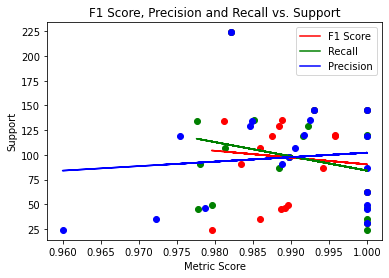

In [176]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# f1s_n = [float(i)/sum(f1s) for i in f1s]
# supports_n = [float(i)/sum(supports) for i in supports]

# corr = np.correlate(f1s_n, supports_n)



fig, ax = plt.subplots()

ax.scatter(f1s, supports, color='r')
ax.scatter(recalls, supports, color='g')
ax.scatter(precisions, supports, color='b')

m, b = np.polyfit(f1s, supports, 1)
ax.plot(f1s, [v * m + b for v in f1s], color='r' )
m, b = np.polyfit(recalls, supports, 1)
ax.plot(recalls, [v * m + b for v in recalls], color='g' )
m, b = np.polyfit(precisions, supports, 1)
ax.plot(precisions, [v * m + b for v in precisions], color='b' )
# ax.plot(recalls, [v * m + b for v in recalls], )
# ax.plot(precisions, [v * m + b for v in precisions])
ax.set_title('F1 Score, Precision and Recall vs. Support')
ax.set_xlabel('Metric Score')
ax.set_ylabel('Support')
ax.legend(['F1 Score', 'Recall', 'Precision'])

In [33]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    vmax = cm.max()
    if normalize:
        title = 'Confusion matrix (normalized)'
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = [[int(j*100) for j in i ] for i in cm]
        cm =np.array(cm)
        vmax = 100
        
    plt.figure(figsize=(8,8))

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=vmax)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar(im,fraction=0.046, pad=0.04)



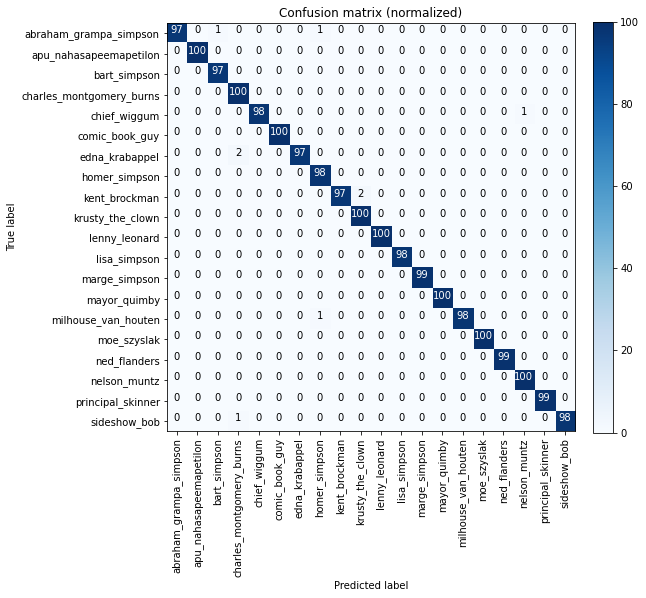

In [34]:
val_ds.reset()
val_ds.shuffle = False
val_ds.next()
y_prob = model.predict(val_ds)
y_pred = y_prob.argmax(axis=-1)
y_true = val_ds.labels
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm=cnf_matrix, classes=class_names, title='Confusion Matrix', normalize=True)


In [188]:
val_ds.reset()
val_ds.shuffle = True
#####################################
######### Show sample of images.
#####################################
plt.figure(figsize=(16, 16))
images = []
labels_pred = []
labels_true = []

count = 20

while len(images) < count:
    chunk = val_ds.next()
    imgs = chunk[0]
    labels = chunk[1]
#         print(itr)
    for i in range(len(imgs)):
        y_proba = model.predict(np.array([imgs[i]]))
        y_pred = np.argmax(y_proba,axis=1)[0]
        y_label = np.argmax(labels[i])
        if y_pred != y_label:
            images.append(imgs[i].astype("uint8"))
            labels_pred.append(y_pred)
            labels_true.append(y_label)
#             print("NA")


<Figure size 1152x1152 with 0 Axes>

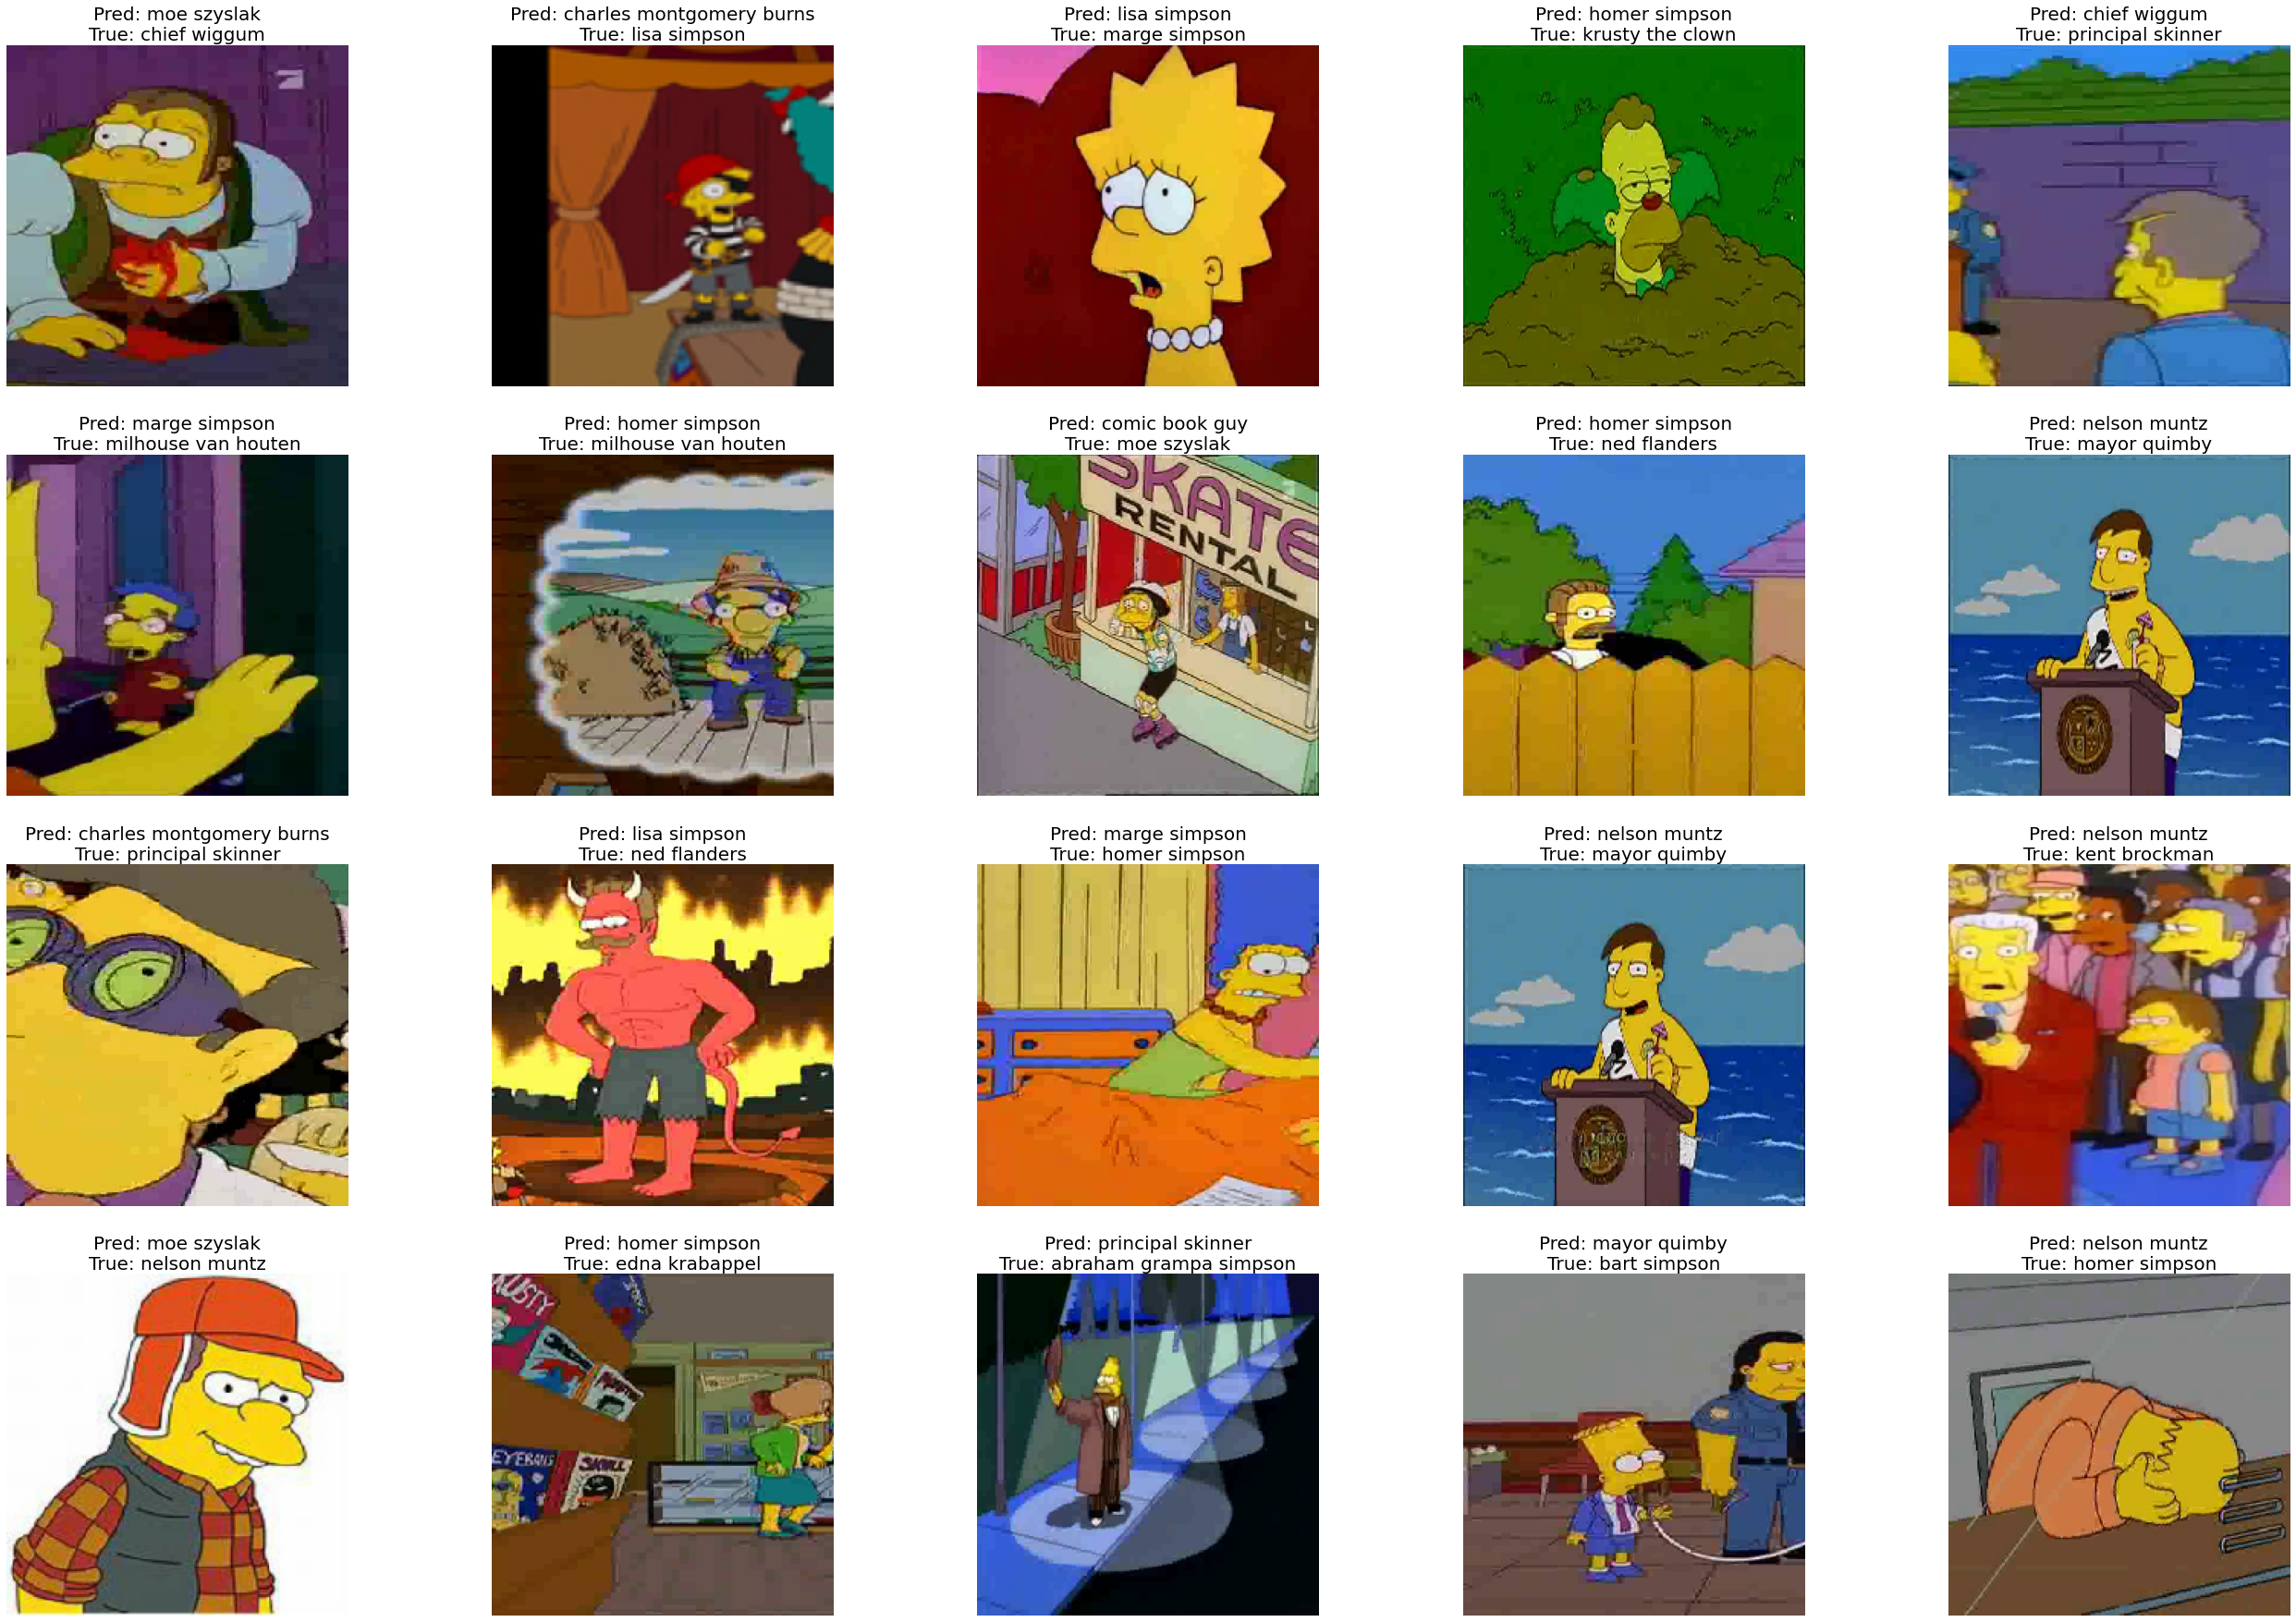

In [189]:
for i in range(len(images)):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i],  aspect='equal')    
    title = 'Pred: ' + class_names[labels_pred[i]].replace('_',' ') +'\n' +'True: ' + class_names[labels_true[i]].replace('_',' ') 


    plt.title(title,fontsize= 20, pad=5)
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=0.1, right=6, top=6, wspace=None, hspace=None)


In [179]:
# model = tf.keras.models.load_model('model-55-0.99.hdf5')
model = load_model('model-48-0.99.hdf5')

In [180]:
'''
    Split train and validation.
'''
# We define the size of input images to 128x128 pixels.
image_size = (224, 224) # 224x224 for MobileNet models, also try 128x128 for other models
# We define the batch size
batch_size = 32

# Create an image generator with a fraction of images reserved for validation:
image_generator = ImageDataGenerator(
#     rotation_range=10, 
#     width_shift_range=0.1,
#     height_shift_range=0.1, 
#    brightness_range=0.1, 
#     horizontal_flip=True,
    validation_split=0.1
    )

# Now, we create a training data iterator by creating batchs of images of the same size as 
# defined previously, i.e., each image is resized in a 64x64 pixels format.
train_ds =  DirectoryIterator(
    "dataset/simpsons_train/",
    image_generator,
    class_mode='categorical',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'training',
)

# Similarly, we create a validation data iterator by creating batchs of images of the same size as 
# defined previously, i.e., each image is resized in a 64x64 pixels format.
val_ds = DirectoryIterator(
    "dataset/simpsons_train/",
    image_generator,
    class_mode='categorical',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'validation',
    shuffle=False
)

# We save the list of classes (labels).
class_names = list(train_ds.class_indices.keys())

# We also save the number of labels.
num_classes = train_ds.num_classes

Found 17603 images belonging to 20 classes.
Found 1945 images belonging to 20 classes.


In [181]:
val_ds.reset()
val_ds.shuffle = False
val_ds.next()
y_prob = model.predict(val_ds)
y_pred = y_prob.argmax(axis=-1)
y_true = val_ds.labels
report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
print(report)

{'abraham_grampa_simpson': {'precision': 0.989010989010989, 'recall': 0.989010989010989, 'f1-score': 0.989010989010989, 'support': 91}, 'apu_nahasapeemapetilon': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 62}, 'bart_simpson': {'precision': 0.9924242424242424, 'recall': 0.9776119402985075, 'f1-score': 0.9849624060150376, 'support': 134}, 'charles_montgomery_burns': {'precision': 0.9754098360655737, 'recall': 1.0, 'f1-score': 0.9875518672199171, 'support': 119}, 'chief_wiggum': {'precision': 0.9797979797979798, 'recall': 0.9897959183673469, 'f1-score': 0.9847715736040609, 'support': 98}, 'comic_book_guy': {'precision': 0.9574468085106383, 'recall': 0.9782608695652174, 'f1-score': 0.967741935483871, 'support': 46}, 'edna_krabappel': {'precision': 1.0, 'recall': 0.9555555555555556, 'f1-score': 0.9772727272727273, 'support': 45}, 'homer_simpson': {'precision': 0.9777777777777777, 'recall': 0.9821428571428571, 'f1-score': 0.9799554565701558, 'support': 224}, 'kent_brockman

In [184]:
keys = list(item for item in report.keys() if item not in ['accuracy', 'macro avg', 'weighted avg'])
bstats = [report[k] for k in keys]
bf1s = [item['f1-score'] for item in bstats]
brecalls = [item['recall'] for item in bstats]
bprecisions = [item['precision'] for item in bstats]
bsupports = [item['support'] for item in bstats]

(0.88, 1.01)

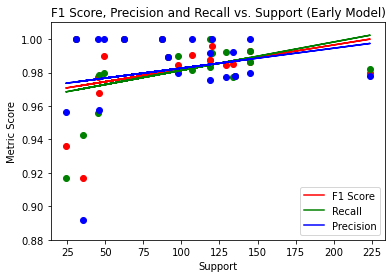

In [199]:
fig, ax = plt.subplots()

ax.scatter(bsupports, bf1s, color='r')
ax.scatter(bsupports, brecalls, color='g')
ax.scatter(bsupports, bprecisions, color='b')

m, b = np.polyfit(bsupports, bf1s, 1)
ax.plot(bsupports, [v * m + b for v in bsupports], color='r' )
m, b = np.polyfit(bsupports, brecalls, 1)
ax.plot(bsupports, [v * m + b for v in bsupports], color='g' )
m, b = np.polyfit(bsupports, bprecisions, 1)
ax.plot(bsupports, [v * m + b for v in bsupports], color='b' )
# ax.plot(recalls, [v * m + b for v in recalls], )
# ax.plot(precisions, [v * m + b for v in precisions])
ax.set_title('F1 Score, Precision and Recall vs. Support (Early Model)')
ax.set_ylabel('Metric Score')
ax.set_xlabel('Support')
ax.legend(['F1 Score', 'Recall', 'Precision'])
ax.set_ylim([0.88,1.01])

(0.88, 1.01)

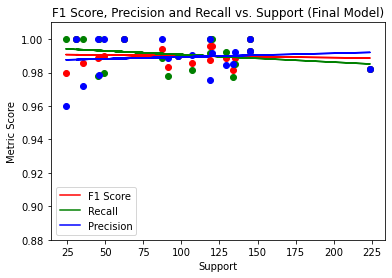

In [200]:
fig, ax = plt.subplots()

ax.scatter(supports, f1s, color='r')
ax.scatter(supports, recalls, color='g')
ax.scatter(supports, precisions, color='b')

m, b = np.polyfit(supports, f1s, 1)
ax.plot(supports, [v * m + b for v in supports], color='r' )
m, b = np.polyfit(supports, recalls, 1)
ax.plot(supports, [v * m + b for v in supports], color='g' )
m, b = np.polyfit(supports, precisions, 1)
ax.plot(supports, [v * m + b for v in supports], color='b' )
# ax.plot(recalls, [v * m + b for v in recalls], )
# ax.plot(precisions, [v * m + b for v in precisions])
ax.set_title('F1 Score, Precision and Recall vs. Support (Final Model)')
ax.set_ylabel('Metric Score')
ax.set_xlabel('Support')
ax.legend(['F1 Score', 'Recall', 'Precision'])
ax.set_ylim([0.88,1.01])